# NLP for stock market prediction

In [16]:
import time
start = time.time()
import os
import numpy as np 
import pandas as pd 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

# 1. Loading the data

This data consists of news articles and the corresponding closing price of stocks following the given topic. 
The objective is to find the relationship between the sentiments contained in the news topics and the closing stock price

In [17]:
df = pd.read_csv("../input/stocknews/Combined_News_DJIA.csv",low_memory=False,
                    parse_dates=[0])

full_stock = pd.read_csv("../input/stocknews/upload_DJIA_table.csv",low_memory=False,
                    parse_dates=[0])

#add the closing stock value to the df - this will be the y variable
df["Close"]=full_stock.Close

#show how the dataset looks like
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Close
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge""",17949.369141
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo...",17929.990234
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man...",17694.679688
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...,17409.720703
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree to missle defense deal. ...,"b'Will the Russians conquer Tblisi? Bet on it,...",...,"b""Georgia confict could set back Russia's 

In [18]:
full_stock.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


# 2. Data cleaning

### NA treatment
We'll simply fill the NAs in the numerical features (Date, Close). 
In the text features we'll fill the missing values with ''.

There are a few headlines missing. Let's fill them in with a whitespace.

In [19]:
df = df.replace(np.nan, ' ', regex=True)

#sanity check
df.isnull().sum().sum()

0

### Remove the HTML tags
This process removes words starting with given tags to reduce the bias in the text corpus

In [20]:
df = df.replace('b\"|b\'|\\\\|\\\"', '', regex=True)
df.head(2)

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25,Close
0,2008-08-08,0,Georgia 'downs two Russian warplanes' as count...,BREAKING: Musharraf to be impeached.',Russia Today: Columns of troops roll into Sout...,Russian tanks are moving towards the capital o...,"Afghan children raped with 'impunity,' U.N. of...",150 Russian tanks have entered South Ossetia w...,"Breaking: Georgia invades South Ossetia, Russi...",The 'enemy combatent' trials are nothing but a...,...,Al-Qaeda Faces Islamist Backlash',Condoleezza Rice: The US would not act to prev...,This is a busy day: The European Union has ap...,"Georgia will withdraw 1,000 soldiers from Iraq...",Why the Pentagon Thinks Attacking Iran is a Ba...,Caucasus in crisis: Georgia invades South Osse...,Indian shoe manufactory - And again in a seri...,Visitors Suffering from Mental Illnesses Banne...,No Help for Mexico's Kidnapping Surge,17949.369141
1,2008-08-11,1,Why wont America and Nato help us? If they won...,Bush puts foot down on Georgian conflict',Jewish Georgian minister: Thanks to Israeli tr...,Georgian army flees in disarray as Russians ad...,Olympic opening ceremony fireworks 'faked',What were the Mossad with fraudulent New Zeala...,Russia angered by Israeli military sale to Geo...,An American citizen living in S.Ossetia blames...,...,"Do not believe TV, neither Russian nor Georgia...",Riots are still going on in Montreal (Canada) ...,China to overtake US as largest manufacturer',War in South Ossetia [PICS]',Israeli Physicians Group Condemns State Torture',Russia has just beaten the United States over...,Perhaps *the* question about the Georgia - Rus...,Russia is so much better at war',So this is what it's come to: trading sex for ...,17929.990234


In the section that follows, the sentiment score of individual topics will be calculated using VADER sentiment analysis tool. 
The tool will consider the data in its raw formart without any preprocessing since it will be important to capture attributes such as existing punctuations and caps in the data. 
The sentiment scores will range from -0.5 which represents extremely negative posts to 0.5 showiing positive sentiments. 

In [21]:
sentiment_analyzer  = SentimentIntensityAnalyzer()

sentiment_analyzer.polarity_scores(" ")

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

we then save the subjectivity score of the given text using TextBlob 

In [22]:
def detect_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

detect_subjectivity(" ") #should return 0

0.0

In [23]:
#get the headline columns' names
cols = []
for i in range(1,26):
    col = ("Top{}".format(i))
    cols.append(col)

#Calculating the polarity scores of the columns

In [24]:
start_vect=time.time()
print("Sentiment Analyzer: 'Intializing the process..'")

#get the name of the headline columns
cols = []
for i in range(1,26):
    col = ("Top{}".format(i))
    cols.append(col)


for col in cols:
    df[col] = df[col].astype(str) # Make sure data is treated as a string
    df[col+'_comp']= df[col].apply(lambda x:sentiment_analyzer.polarity_scores(x)['compound'])
    df[col+'_sub'] = df[col].apply(detect_subjectivity)
    print("{} Done".format(col))
    
print("VADER: Vaderization completed after %0.2f Minutes"%((time.time() - start_vect)/60))

Sentiment Analyzer: 'Intializing the process..'
Top1 Done
Top2 Done
Top3 Done
Top4 Done
Top5 Done
Top6 Done
Top7 Done
Top8 Done
Top9 Done
Top10 Done
Top11 Done
Top12 Done
Top13 Done
Top14 Done
Top15 Done
Top16 Done
Top17 Done
Top18 Done
Top19 Done
Top20 Done
Top21 Done
Top22 Done
Top23 Done
Top24 Done
Top25 Done
VADER: Vaderization completed after 0.80 Minutes


In [25]:
df = df.drop(cols,axis=1)
df.head(5)

,Date,Label,Close,Top1_comp,Top1_sub,Top2_comp,Top2_sub,Top3_comp,Top3_sub,Top4_comp,...,Top21_comp,Top21_sub,Top22_comp,Top22_sub,Top23_comp,Top23_sub,Top24_comp,Top24_sub,Top25_comp,Top25_sub
0,2008-08-08,0,17949.369141,-0.5994,0.0,0.0000,0.000000,-0.3612,0.000000,-0.7089,...,-0.7579,0.666667,-0.6249,0.0,-0.2755,0.00,-0.8519,0.200000,0.1280,0.0
1,2008-08-11,1,17929.990234,0.8156,0.0,-0.3182,0.288889,0.4404,0.100000,-0.1965,...,-0.8020,0.000000,0.0000,0.0,-0.3182,0.00,-0.1832,0.500000,0.0000,0.0
2,2008-08-12,0,17694.679688,0.0258,1.0,0.0000,0.000000,-0.7845,0.833333,-0.6124,...,-0.5994,0.000000,0.5267,0.0,0.3818,0.35,0.0000,0.454545,0.0000,0.0
3,2008-08-13,0,17409.720703,-0.7184,0.0,-0.8074,0.000000,-0.6369,0.000000,-0.1280,...,-0.2960,0.000000,0.4939,0.0,-0.5719,0.00,-0.4215,0.100000,-0.3400,0.0
4,2008-08-14,1,17140.240234,0.2023,0.0,-0.5994,0.000000,0.6808,0.400000,-0.8689,...,-0.4404,0.000000,-0.5994,0.0,0.1779,0.00,-0.6908,0.500000,0.7096,0.0


Summarise the compound and subjectivity scores weighted by rating of the headline (top1 has the most weight)

In [26]:
comp_cols = []
for col in cols:
    comp_col = col + "_comp"
    comp_cols.append(comp_col)

w = np.arange(1,26,1).tolist()
w.reverse()

weighted_comp = []
max_comp = []
min_comp = []
for i in range(0,len(df)):
    a = df.loc[i,comp_cols].tolist()
    weighted_comp.append(np.average(a, weights=w))
    max_comp.append(max(a))
    min_comp.append(min(a))

df['compound_mean'] = weighted_comp
df['compound_max'] = max_comp
df['compound_min'] = min_comp


sub_cols = []
for col in cols:
    sub_col = col + "_sub"
    sub_cols.append(sub_col)


weighted_sub = []
max_sub = []
min_sub = []
for i in range(0,len(df)):
    a = df.loc[i,sub_cols].tolist()
    weighted_sub.append(np.average(a, weights=w))
    max_sub.append(max(a))
    min_sub.append(min(a))

df['subjectivity_mean'] = weighted_sub
df['subjectivity_max'] = max_sub
df['subjectivity_min'] = min_sub

to_drop = sub_cols+comp_cols
df = df.drop(to_drop, axis=1)

In [27]:
df.head(5)

,Date,Label,Close,compound_mean,compound_max,compound_min,subjectivity_mean,subjectivity_max,subjectivity_min
0,2008-08-08,0,17949.369141,-0.350337,0.2144,-0.9260,0.163685,0.666667,0.0
1,2008-08-11,1,17929.990234,-0.085277,0.8156,-0.8271,0.202921,0.720000,0.0
2,2008-08-12,0,17694.679688,-0.318394,0.5423,-0.8591,0.374076,1.000000,0.0
3,2008-08-13,0,17409.720703,-0.162032,0.5106,-0.8074,0.176371,0.900000,0.0
4,2008-08-14,1,17140.240234,-0.194879,0.7177,-0.8689,0.319615,1.000000,0.0


# 4. Explorative Data Analysis

First, the timeseries of the target (to be predicted) variable will be explored. It's likely the the timeseries isn't stationary( the mean and the variance will be changing with time) which however doesn't worry us in this case as the models won't be of the classical timeseries methods family.


In [28]:
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=df.Date, y=df.Close,
                    mode='lines'))
title = []
title.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Stock value evolution from Aug, 2008 to Jun, 2016',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig1.update_layout(xaxis_title='Date',
                   yaxis_title='Closing stock value (in $)',
                  annotations=title)
fig1.show()

Stock prices have been on a downward trajectory. I wonder why?
Let's understand the various unstationarity present in the data

In [29]:
#function for quick plotting and testing of stationarity
def stationary_plot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

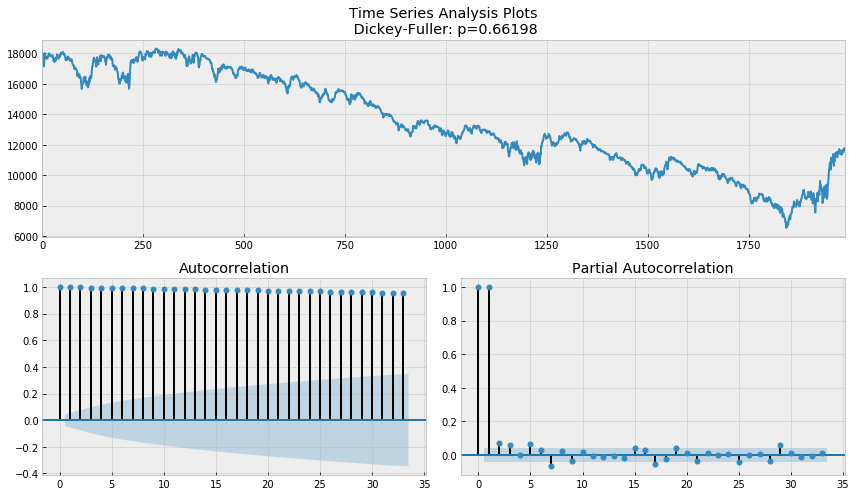

In [30]:
stationary_plot(df.Close)

The degree of unstationarity is significantly high. The data will be made stationary for purposes of knowledge anyways

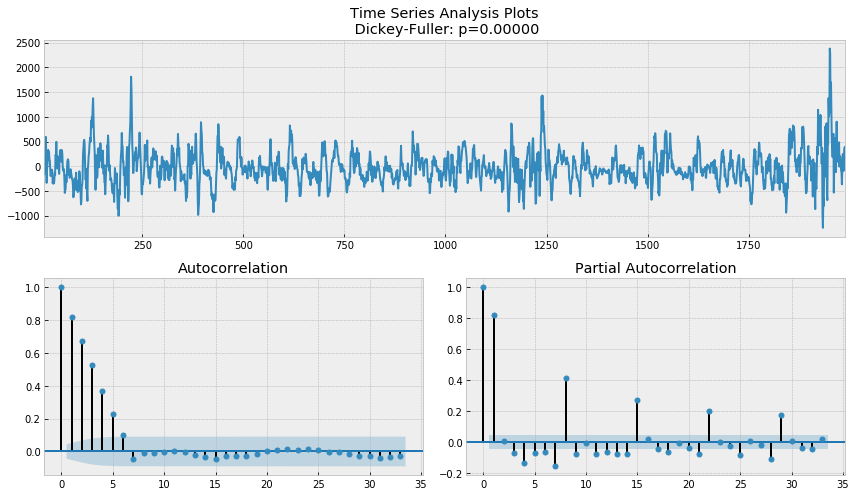

In [31]:
diff = df.Close - df.Close.shift(7)
stationary_plot(diff[7:])

It seems that removing weekly seasonality helped a bit but the autocorrelation plot still shows many significant lags.

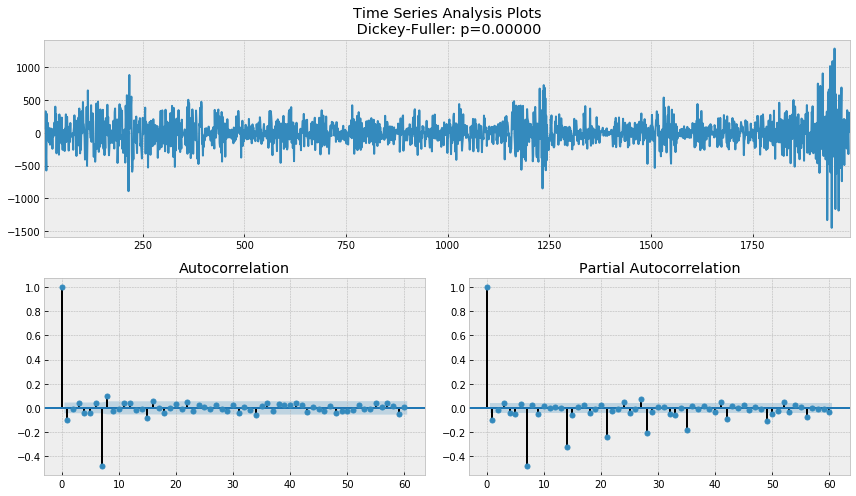

In [32]:
diff2 = diff - diff.shift(1)
stationary_plot(diff2[7+1:], lags=60)

Next we look at the compound sentiment scores.

In [33]:
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=df.Date, y=df.compound_mean,
                    mode='lines',
                    name='Mean'))
fig2.add_trace(go.Scatter(x=df.Date, y=df.compound_max,
                    mode='lines',
                    name='Maximum'))
fig2.add_trace(go.Scatter(x=df.Date, y=df.compound_min,
                    mode='lines',
                    name='Minimum'))
title = []
title.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Development of sentiment compound score',
                               font=dict(family='Arial',
                                       size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig2.update_layout(xaxis_title='Date',
                   yaxis_title='Compound score',
                  annotations=title)
fig2.show()

Let's also plot the distribution of the compound score.

In [35]:
compm_hist = px.histogram(df, x="compound_mean")
compm_hist.show()

And the subjectivity scores

In [36]:
fig3 = go.Figure()
fig3.add_trace(go.Scatter(x=df.Date, y=df.subjectivity_mean,
                    mode='lines',
                    name='Mean'))
fig3.add_trace(go.Scatter(x=df.Date, y=df.subjectivity_min,
                    mode='lines',
                    name='Min'))
fig3.add_trace(go.Scatter(x=df.Date, y=df.subjectivity_max,
                    mode='lines',
                    name='Max'))
title = []
title.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Development of subjectivity score',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))
fig3.update_layout(xaxis_title='Date',
                   yaxis_title='Subjectivity score',
                  annotations=title)
fig3.show()

Now we plot distribution of the subjectivity scores as well.

In [37]:
subm_hist = px.histogram(df, x="subjectivity_mean")
subm_hist.show()

Next we'll look at some descriptive statistics about the data.

In [38]:
df.describe()

,Label,Close,compound_mean,compound_max,compound_min,subjectivity_mean,subjectivity_max,subjectivity_min
count,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.000000,1989.0
mean,0.535445,13463.032255,-0.214048,0.655888,-0.885830,0.251779,0.892645,0.0
std,0.498867,3144.006996,0.106812,0.166124,0.062723,0.066196,0.144796,0.0
min,0.000000,6547.049805,-0.546383,0.000000,-0.989800,0.080897,0.416667,0.0
25%,0.000000,10913.379883,-0.283676,0.542300,-0.931600,0.205581,0.785714,0.0
50%,1.000000,13025.580078,-0.211782,0.670500,-0.897900,0.249927,1.000000,0.0
75%,1.000000,16478.410156,-0.142235,0.784500,-0.851900,0.297009,1.000000,0.0
max,1.000000,18312.390625,0.166370,0.962300,-0.571900,0.470498,1.000000,0.0


# Feature selection
The best features for the stock prediction will be selected based on their variance and uniqueness as follows

In [39]:
def unique_ratio (col):
    return len(np.unique(col))/len(col)

cols = ['Close', 'compound_mean', 'compound_max', 'compound_min', 'subjectivity_mean', 'subjectivity_max', 'subjectivity_min']

ur = []
var = []
for col in cols:
    ur.append(unique_ratio(df[col]))
    var.append(np.var(df[col]))
    
feature_sel = pd.DataFrame({'Column': cols, 
              'Unique': ur,
              'Variance': var})
feature_sel

,Column,Unique,Variance
0,Close,0.994470,9.879810e+06
1,compound_mean,1.000000,1.140312e-02
2,compound_max,0.184515,2.758317e-02
3,compound_min,0.174460,3.932207e-03
4,subjectivity_mean,0.999497,4.379750e-03
5,subjectivity_max,0.083962,2.095546e-02
6,subjectivity_min,0.000503,0.000000e+00


In [40]:
sel_fig = go.Figure(data=go.Scatter(
    x=feature_sel.Column,
    y=feature_sel.Unique,
    mode='markers',
    marker=dict(size=(feature_sel.Unique*100)),
))
sel_fig.update_layout(title='Ratio of unique values', 
                      yaxis_title='Unique ratio')
sel_fig.show()

The minimum and maximum subjectivity are dropped due to their less diversity

In [41]:
drop = ['subjectivity_min', 'subjectivity_max']
clean_df = df.drop(drop,axis=1)

# 5. Lag the extracted features
Lag features are useful when it comes to telling us how the past information may influence the present stock prices. 
We use a lag period of 7 days for this purpose


In [42]:
lag_df = clean_df.copy()
lag_df.head(3)

,Date,Label,Close,compound_mean,compound_max,compound_min,subjectivity_mean
0,2008-08-08,0,17949.369141,-0.350337,0.2144,-0.9260,0.163685
1,2008-08-11,1,17929.990234,-0.085277,0.8156,-0.8271,0.202921
2,2008-08-12,0,17694.679688,-0.318394,0.5423,-0.8591,0.374076


In [43]:
to_lag = list(lag_df.columns)
to_lag_4 = to_lag[1]
to_lag_1 = to_lag[2:len(to_lag)]

In [44]:
#lagging text features two days back
for col in to_lag_1:
    for i in range(1,3):
        new_name = col + ('_lag_{}'.format(i))
        lag_df[new_name] = lag_df[col].shift(i)
    
#lagging closing values 4 days back
for i in range(1, 5):
    new_name = to_lag_4 + ('_lag_{}'.format(i))
    lag_df[new_name] = lag_df[to_lag_4].shift(i)

In this process, rows with NAs were created. These will be dropped

In [45]:
#Show many rows need to be removed
lag_df.head(10) 

,Date,Label,Close,compound_mean,compound_max,compound_min,subjectivity_mean,Close_lag_1,Close_lag_2,compound_mean_lag_1,...,compound_max_lag_1,compound_max_lag_2,compound_min_lag_1,compound_min_lag_2,subjectivity_mean_lag_1,subjectivity_mean_lag_2,Label_lag_1,Label_lag_2,Label_lag_3,Label_lag_4
0,2008-08-08,0,17949.369141,-0.350337,0.2144,-0.9260,0.163685,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2008-08-11,1,17929.990234,-0.085277,0.8156,-0.8271,0.202921,17949.369141,NaN,-0.350337,...,0.2144,NaN,-0.9260,NaN,0.163685,NaN,0.0,NaN,NaN,NaN
2,2008-08-12,0,17694.679688,-0.318394,0.5423,-0.8591,0.374076,17929.990234,17949.369141,-0.085277,...,0.8156,0.2144,-0.8271,-0.9260,0.202921,0.163685,1.0,0.0,NaN,NaN
3,2008-08-13,0,17409.720703,-0.162032,0.5106,-0.8074,0.176371,17694.679688,17929.990234,-0.318394,...,0.5423,0.8156,-0.8591,-0.8271,0.374076,0.202921,0.0,1.0,0.0,NaN
4,2008-08-14,1,17140.240234,-0.194879,0.7177,-0.8689,0.319615,17409.720703,17694.679688,-0.162032,...,0.5106,0.5423,-0.8074,-0.8591,0.176371,0.374076,0.0,0.0,1.0,0.0
5,2008-08-15,1,17400.750000,-0.143104,0.4404,-0.7481,0.227282,17140.240234,17409.720703,-0.194879,...,0.7177,0.5106,-0.8689,-0.8074,0.319615,0.176371,1.0,0.0,0.0,1.0
6,2008-08-18,0,18011.070312,-0.263546,0.5106,-0.9260,0.216935,17400.750000,17140.240234,-0.143104,...,0.4404,0.7177,-0.7481,-0.8689,0.227282,0.319615,1.0,1.0,0.0,0.0
7,2008-08-19,0,17780.830078,-0.360490,0.5719,-0.8720,0.256786,18011.070312,17400.750000,-0.263546,...,0.5106,0.4404,-0.9260,-0.7481,0.216935,0.227282,0.0,1.0,1.0,0.0
8,2008-08-20,1,17829.730469,-0.231969,0.4588,-0.8807,0.095403,17780.830078,18011.070312,-0.360490,...,0.5719,0.5106,-0.8720,-0.9260,0.256786,0.216935,0.0,0.0,1.0,1.0
9,2008-08-21,1,17804.869141,-0.268522,0.5719,-0.9022,0.107994,17829.730469,17780.830078,-0.231969,...,0.4588,0.5719,-0.8807,-0.8720,0.095403,0.256786,1.0,0.0,0.0,1.0


Above we can see that the first 7 rows now have missing values. Let's delete them and reset index.

In [46]:
lag_df = lag_df.drop(lag_df.index[[np.arange(0,4)]])
lag_df = lag_df.reset_index(drop=True)

#sanity check for NaNs
lag_df.isnull().sum().sum()

/opt/conda/lib/python3.6/site-packages/pandas/core/indexes/base.py:4291: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



0

In [47]:
lag_df.head(5)

,Date,Label,Close,compound_mean,compound_max,compound_min,subjectivity_mean,Close_lag_1,Close_lag_2,compound_mean_lag_1,...,compound_max_lag_1,compound_max_lag_2,compound_min_lag_1,compound_min_lag_2,subjectivity_mean_lag_1,subjectivity_mean_lag_2,Label_lag_1,Label_lag_2,Label_lag_3,Label_lag_4
0,2008-08-14,1,17140.240234,-0.194879,0.7177,-0.8689,0.319615,17409.720703,17694.679688,-0.162032,...,0.5106,0.5423,-0.8074,-0.8591,0.176371,0.374076,0.0,0.0,1.0,0.0
1,2008-08-15,1,17400.750000,-0.143104,0.4404,-0.7481,0.227282,17140.240234,17409.720703,-0.194879,...,0.7177,0.5106,-0.8689,-0.8074,0.319615,0.176371,1.0,0.0,0.0,1.0
2,2008-08-18,0,18011.070312,-0.263546,0.5106,-0.9260,0.216935,17400.750000,17140.240234,-0.143104,...,0.4404,0.7177,-0.7481,-0.8689,0.227282,0.319615,1.0,1.0,0.0,0.0
3,2008-08-19,0,17780.830078,-0.360490,0.5719,-0.8720,0.256786,18011.070312,17400.750000,-0.263546,...,0.5106,0.4404,-0.9260,-0.7481,0.216935,0.227282,0.0,1.0,1.0,0.0
4,2008-08-20,1,17829.730469,-0.231969,0.4588,-0.8807,0.095403,17780.830078,18011.070312,-0.360490,...,0.5719,0.5106,-0.8720,-0.9260,0.256786,0.216935,0.0,0.0,1.0,1.0


# 8. Model training
As is common in most machine learning processes, it is important to try out different algorithms using different kinds of data. 
Therefore, in this section, three algorithms will be considered using only econometric models, NLP models and a combination of both. 
The result of the three approaches will then be compared to find the best solution

The first step will be creating folds for cross-validation. We'll use the same folds for all models in order to allow for creating a meta-model. Since we're working with timeseries the folds cannot be randomly selected. Instead a fold will be a sequence of data so that we don't lose the time information.

In [48]:
# for time-series cross-validation set 10 folds 
tscv = TimeSeriesSplit(n_splits=10)

The cost function to minimize is mean squared error because this function assigns cost proportionally to the error size. The mean absolute percentage error will be used for plotting and easier interpretation. It's much easier to understand the errors of a model in terms of percentage.
Each training set is scaled (normalized) independently to minimize data leakage.

In [49]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
scorer = make_scorer(mean_squared_error)
scaler = StandardScaler()   

Next we split the dataset into training and testing. 20% of the data will be used for testing.

In [50]:
def ts_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [51]:
X = lag_df.drop(['Close'],axis=1)
X.index = X["Date"]
X = X.drop(['Date'],axis=1)
y = lag_df.Close

X_train, X_test, y_train, y_test = ts_train_test_split(X, y, test_size = 0.2)

#sanity check
(len(X_train)+len(X_test))==len(X)

True

In [52]:
#function for plotting coeficients of models (lasso and XGBoost)
def plotCoef(model,train_x):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, train_x.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

# 8.1 Econometric models
First let's train models using only the lags of the y variable (i.e. Close).

In [ ]:
econ_cols = list(X_train.columns)
econ_cols = econ_cols[12:17]
X_train_e = X_train[econ_cols]
X_test_e = X_test[econ_cols]
y_train_e = y_train
y_test_e = y_test

In [ ]:
econ_perf = pd.DataFrame(columns=['Model','MSE', 'SD'])
econ_perf

### Ridge regression

In [ ]:
ridge_param = {'model__alpha': list(np.arange(0.001,1,0.001))}
ridge = Ridge(max_iter=5000)
pipe = Pipeline([
    ('scale', scaler),
    ('model', ridge)])
search_ridge = GridSearchCV(estimator=pipe,
                          param_grid = ridge_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4
                         )
search_ridge.fit(X_train_e, y_train_e)

In [ ]:
ridge_e = search_ridge.best_estimator_

#get cv results of the best model + confidence intervals
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(ridge_e, X_train_e, y_train_e, cv=tscv, scoring=scorer)
econ_perf = econ_perf.append({'Model':'Ridge', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
ridge_e

In [ ]:
plotCoef(ridge_e['model'], X_train_e)

In [ ]:
coefs = ridge_e['model'].coef_
ridge_coefs = pd.DataFrame({'Coef': coefs,
                           'Name': list(X_train_e.columns)})
ridge_coefs["abs"] = ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
ridge_coefs

In [ ]:
econ_perf

## Random forest

In [ ]:
rf_param = {'model__n_estimators': [10, 100, 300],
            'model__max_depth': [10, 20, 30, 40],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 3],
            'model__max_features': ["auto", 'sqrt']}

In [ ]:
rf = RandomForestRegressor()
pipe = Pipeline([
    ('scale', scaler),
    ('model', rf)])
gridsearch_rf = GridSearchCV(estimator=pipe,
                          param_grid = rf_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )

In [ ]:
gridsearch_rf.fit(X_train_e, y_train_e)

In [ ]:
rf_e = gridsearch_rf.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(rf_e, X_train_e, y_train_e, cv=tscv, scoring=scorer)
econ_perf = econ_perf.append({'Model':'RF', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)

### XGBoost
Using linear booster because tree methods don't work with timeseries very well

In [ ]:
xgb_param = {'model__lambda': list(np.arange(0.1,3, 0.1)), #L2 regularisation
             'model__alpha': list(np.arange(0.1,3, 0.1)),  #L1 regularisation
            }

In [ ]:
xgb = XGBRegressor(booster='gblinear', feature_selector='shuffle', objective='reg:squarederror')

pipe = Pipeline([
    ('scale', scaler),
    ('model', xgb)])
gridsearch_xgb = GridSearchCV(estimator=pipe,
                          param_grid = xgb_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )

In [ ]:
gridsearch_xgb.fit(X_train_e, y_train_e)

In [ ]:
xgb_e = gridsearch_xgb.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(xgb_e, X_train_e, y_train_e, cv=tscv, scoring=scorer)
econ_perf = econ_perf.append({'Model':'XGB', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
xgb_e

In [ ]:
print(econ_perf)

Plot performance of econ models including error bars

In [ ]:
econ_fig = px.scatter(econ_perf, x="Model", y='MSE', color='Model', error_y="SD")
econ_fig.update_layout(title_text="Performance of models trained on lags of y")
econ_fig.show()

## NLP models
Let's try now predict the stock value using only information from the news headlines.

In [ ]:
X_train_n = X_train.drop(econ_cols, axis=1)
X_test_n = X_test.drop(econ_cols, axis=1)
y_train_n = y_train
y_test_n = y_test

In [ ]:
nlp_perf = pd.DataFrame(columns=['Model','MSE', 'SD'])
nlp_perf

## Ridge regression

In [ ]:
ridge_param = {'model__alpha': list(np.arange(1,10,0.1))}
ridge = Ridge(max_iter=5000)
pipe = Pipeline([
    ('scale', scaler),
    ('model', ridge)
])
search_ridge = GridSearchCV(estimator=pipe,
                          param_grid = ridge_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4
                         )
search_ridge.fit(X_train_n, y_train_n)

In [ ]:
ridge_n = search_ridge.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(ridge_n, X_train_n, y_train_n, cv=tscv, scoring=scorer)
nlp_perf = nlp_perf.append({'Model':'Ridge', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
ridge_n

In [ ]:
plotCoef(ridge_n['model'], X_train_n)

coefs = ridge_n['model'].coef_
ridge_coefs = pd.DataFrame({'Coef': coefs,
                           'Name': list(X_train_n.columns)})
ridge_coefs["abs"] = ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
ridge_coefs

In [ ]:
mape(y_test, ridge_n.predict(X_test_n))

## Random Forest

In [ ]:
rf_param = {'model__n_estimators': [10, 100, 300],
            'model__max_depth': [10, 20, 30, 40],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 3],
            'model__max_features': ["auto", 'sqrt']}
rf = RandomForestRegressor()
pipe = Pipeline([
    ('scale', scaler),
    ('model', rf)])
gridsearch_rf = GridSearchCV(estimator=pipe,
                          param_grid = rf_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )
gridsearch_rf.fit(X_train_n, y_train_n)

In [ ]:
rf_n = gridsearch_rf.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(rf_n, X_train_n, y_train_n, cv=tscv, scoring=scorer)
nlp_perf = nlp_perf.append({'Model':'RF', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)

## XGBoost

In [ ]:
xgb_param = {'model__lambda': list(np.arange(1,10, 1)), #L2 regularisation
             'model__alpha': list(np.arange(1,10, 1)),  #L1 regularisation
            }
xgb = XGBRegressor(booster='gblinear', feature_selector='shuffle', objective='reg:squarederror')

pipe = Pipeline([
    ('scale', scaler),
    ('model', xgb)])
gridsearch_xgb = GridSearchCV(estimator=pipe,
                          param_grid = xgb_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )
gridsearch_xgb.fit(X_train_n, y_train_n)

In [ ]:
xgb_n = gridsearch_xgb.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(xgb_n, X_train_n, y_train_n, cv=tscv, scoring=scorer)
nlp_perf = nlp_perf.append({'Model':'XGB', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
xgb_n

In [ ]:
print(nlp_perf)

In [ ]:
nlp_fig = px.scatter(nlp_perf, x="Model", y='MSE', color='Model', error_y="SD")
#nlp_fig.update_layout(title_text="Performance of models trained on NLP features",
nlp_fig.show()

The 3 models are performing quite similary. They might be useful candidates for stacking.

# Econ+NLP models
Let's use all features now

## Ridge regression

In [53]:
en_perf = pd.DataFrame(columns=['Model','MSE', 'SD'])
en_perf

,Model,MSE,SD


In [54]:
ridge_param = {'model__alpha': list(np.arange(0.1,1,0.01))}
ridge = Ridge(max_iter=5000)
pipe = Pipeline([
    ('scale', scaler),
    ('model', ridge)])
search_ridge = GridSearchCV(estimator=pipe,
                          param_grid = ridge_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )
search_ridge.fit(X_train, y_train)

Fitting 10 folds for each of 90 candidates, totalling 900 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done 900 out of 900 | elapsed:    5.9s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=5000,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid=...
                                          0.2699999999999999,
                                          0.279999

In [55]:
ridge_en = search_ridge.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(ridge_en, X_train, y_train, cv=tscv, scoring=scorer)
en_perf = en_perf.append({'Model':'Ridge', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
ridge_en

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 Ridge(alpha=0.9899999999999995, copy_X=True,
                       fit_intercept=True, max_iter=5000, normalize=False,
                       random_state=None, solver='auto', tol=0.001))],
         verbose=False)

In [56]:
coefs = ridge_en['model'].coef_
ridge_coefs = pd.DataFrame({'Coef': coefs,
                           'Name': list(X_train.columns)})
ridge_coefs["abs"] = ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
ridge_coefs

,Coef,Name
5,2057.719466,Close_lag_1
6,487.038186,Close_lag_2
12,7.936414,compound_min_lag_2
1,7.922717,compound_mean
10,5.495262,compound_max_lag_2
2,-5.034918,compound_max
17,-3.685036,Label_lag_3
13,-2.497308,subjectivity_mean_lag_1
18,-2.257206,Label_lag_4
8,-2.062236,compound_mean_lag_2


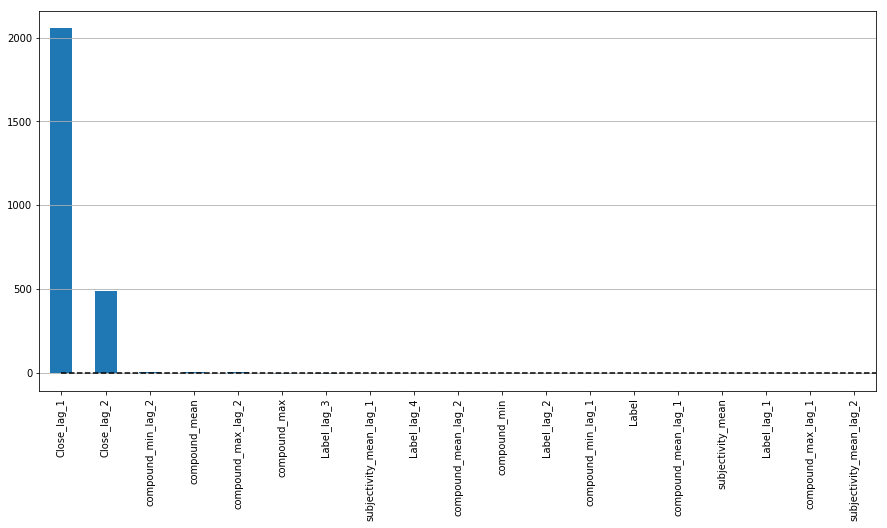

In [57]:
plotCoef(ridge_en['model'], X_train)

## Random Forest

In [58]:
rf_param = {'model__n_estimators': [10, 100, 300],
            'model__max_depth': [10, 20, 30, 40],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 3],
            'model__max_features': ["auto", 'sqrt']}
rf = RandomForestRegressor()
pipe = Pipeline([
    ('scale', scaler),
    ('model', rf)])
gridsearch_rf = GridSearchCV(estimator=pipe,
                          param_grid = rf_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )
gridsearch_rf.fit(X_train, y_train)

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  57 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 156 tasks      | elapsed:   44.8s
[Parallel(n_jobs=4)]: Done 316 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 540 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 828 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done 1180 tasks      | elapsed:  4.2min
[Parallel(n_jobs=4)]: Done 1596 tasks      | elapsed:  5.5min
[Parallel(n_jobs=4)]: Done 2076 tasks      | elapsed:  7.3min
[Parallel(n_jobs=4)]: Done 2160 out of 2160 | elapsed:  7.5min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        RandomForestRegressor(bootstrap=True,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                             

In [59]:
rf_en = gridsearch_rf.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(rf_en, X_train, y_train, cv=tscv, scoring=scorer)
en_perf = en_perf.append({'Model':'RF', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
rf_en

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=10, max_features='sqrt',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=2, min_samples_split=10,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

## XGBoost

In [60]:
xgb_param = {'model__lambda': list(np.arange(1,10, 1)), #L2 regularisation
             'model__alpha': list(np.arange(1,10, 1)),  #L1 regularisation
            }
xgb = XGBRegressor(booster='gblinear', feature_selector='shuffle', objective='reg:squarederror')

pipe = Pipeline([
    ('scale', scaler),
    ('model', xgb)])
gridsearch_xgb = GridSearchCV(estimator=pipe,
                          param_grid = xgb_param,
                          scoring = scorer,
                          cv = tscv,
                          n_jobs=4,
                          verbose=3
                         )
gridsearch_xgb.fit(X_train, y_train)

Fitting 10 folds for each of 81 candidates, totalling 810 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 456 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 810 out of 810 | elapsed:   14.2s finished
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning:

Series.base is deprecated and will be removed in a future version



GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('model',
                                        XGBRegressor(base_score=0.5,
                                                     booster='gblinear',
                                                     colsample_bylevel=1,
                                                     colsample_bynode=1,
                                                     colsample_bytree=1,
                                                     feature_selector='shuffle',
                                                     gamma=0,
                              

In [61]:
xgb_en = gridsearch_xgb.best_estimator_

#get cv results of the best model + confidence intervals
cv_score = cross_val_score(xgb_en, X_train, y_train, cv=tscv, scoring=scorer)
en_perf = en_perf.append({'Model':'XGB', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}, ignore_index=True)
xgb_en

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning:

Series.base is deprecated and will be removed in a future version


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 XGBRegressor(alpha=1, base_score=0.5, booster='gblinear',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, feature_selector='shuffle',
                              gamma=0, importance_type='gain', lambda=1,
                              learning_rate=0.1, max_delta_step=0, max_depth=3,
                              min_child_weight=1, missing=None,
                              n_estimators=100, n_jobs=1, nthread=None,
                              objective='reg:squarederror', random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              seed=None, silent=None, subsample=1,
                              verbosity=1))],
         verbose=False)

# Try stacking econometric and NLP models

In [62]:
from sklearn.model_selection import cross_val_predict

X_train_stack = pd.DataFrame(pd.DataFrame(columns=['econ_r', 'nlp_r']))
X_train_stack['econ_r'] = cross_val_predict(ridge_e, X_train_e, y_train, cv=10)
X_train_stack['nlp_r'] = cross_val_predict(ridge_n, X_train_n, y_train, cv=10)

X_test_stack = pd.DataFrame(pd.DataFrame(columns=['econ_r', 'nlp_r']))
X_test_stack['econ_r'] = ridge_e.predict(X_test_e)
X_test_stack['nlp_r'] = ridge_n.predict(X_test_n)

X_train_stack.to_csv("Stack_train.csv")
X_test_stack.to_csv("Stack_test.csv")

from sklearn.linear_model import ElasticNetCV
stack = ElasticNetCV(cv=tscv)
stack.fit(X_train_stack, y_train)
cv_score = cross_val_score(stack, X_train_stack, y_train, cv=tscv, scoring=scorer)
stack_performance = {'Model':'XGB', 'MSE':np.mean(cv_score), 'SD':(np.std(cv_score))}
stack_performance

mape(y_test, stack.predict(X_test_stack))

NameError: name 'ridge_e' is not defined

In [ ]:
coefs = stack.coef_
ridge_coefs = pd.DataFrame({'Coef': coefs,
                           'Name': list(X_train_stack.columns)})
ridge_coefs["abs"] = ridge_coefs.Coef.apply(np.abs)
ridge_coefs = ridge_coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
print(ridge_coefs)
plotCoef(stack, X_train_stack)

# Model comparison

In [ ]:
prediction_compare = pd.DataFrame(pd.DataFrame(columns=['y_true', 'econ_r', 'econ_rf', 'econ_x', 'nlp_r', 'nlp_rf', 'nlp_x', 'comb_r', 'comb_rf', 'comb_x', 'stack']))
prediction_compare['y_true'] = y_test
prediction_compare['econ_r'] = ridge_e.predict(X_test_e)
prediction_compare['econ_rf'] = rf_e.predict(X_test_e)
prediction_compare['econ_x'] = xgb_e.predict(X_test_e)
prediction_compare['nlp_r'] = ridge_n.predict(X_test_n)
prediction_compare['nlp_rf'] = rf_n.predict(X_test_n)
prediction_compare['nlp_x'] = xgb_n.predict(X_test_n)
prediction_compare['comb_r'] = ridge_en.predict(X_test)
prediction_compare['comb_rf'] = rf_en.predict(X_test)
prediction_compare['comb_x'] = xgb_en.predict(X_test)
prediction_compare['stack'] = stack.predict(X_test_stack)

prediction_compare.sample(3)

In [ ]:
econ_perf.to_csv("econ_perf.csv")
nlp_perf.to_csv("nlp_perf.csv")
en_perf.to_csv("en_perf.csv")
prediction_compare.to_csv('compare_predictions.csv')
X_test.to_csv('X_test.csv')

# Stacking classification and regression
Using NLP features in the above models turned out to by highly ineffective. There are, however some problems of the econometric models that NLP features might be able to solve. From other kernels you can see that they can be used for predicting whether the stock value will go up or down. In following section, we'll train direction classifier with NLP features and use the output of this model to improve the econometric models.